In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests

character_metadata_path = "../../data/character.metadata.tsv"
movie_metadata_path = "../../data/movie.metadata.tsv"
name_cluster_path = "../../data/name.clusters.tsv"
plot_summaries_path = "../../data/plot_summaries.tsv"
tvtropes_path = "../../data/tvtropes.clusters.tsv"
fb_to_wiki_path = "../../data/fb_wiki_mapping.tsv"

# read data
characterMetadata = pd.read_csv(character_metadata_path, sep="\t")
movieMetadata = pd.read_csv(movie_metadata_path, sep="\t")
nameCluster = pd.read_csv(
    name_cluster_path,
    sep="\t",
    names=["Character name", "Freebase character/actor map ID"],
)
plotSummaries = pd.read_csv(
    plot_summaries_path, sep="\t", names=["Wikipedia movie ID", "plot"]
)
tvtropes = pd.read_csv(tvtropes_path, sep="\t", names=["trope", "details"])

tvtropes = pd.concat(
    [tvtropes["trope"], tvtropes["details"].apply(json.loads).apply(pd.Series)], axis=1
)
tvtropes = tvtropes.rename(columns={"id": "Freebase character/actor map ID"})

fb_to_wiki = pd.read_csv(fb_to_wiki_path, sep="\t")

In [3]:
# Extracting the values from the json columns
def extract_values(json_col):
    return json_col.apply(lambda x: ', '.join(json.loads(x).values()) if pd.notnull(x) else x)
movieMetadata['Movie languages'] = extract_values(movieMetadata['Movie languages (Freebase ID:name tuples)'])
movieMetadata['Movie countries'] = extract_values(movieMetadata['Movie countries (Freebase ID:name tuples)'])
movieMetadata['Movie genres'] = extract_values(movieMetadata['Movie genres (Freebase ID:name tuples)'])
movieMetadata.drop(columns=['Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 'Movie genres (Freebase ID:name tuples)'], inplace=True)

# film release year
movieMetadata['Movie release date'] = movieMetadata['Movie release date'].astype(str).str[:4]
characterMetadata['Movie release date'] = characterMetadata['Movie release date'].astype(str).str[:4]

# Map the ethnicity id to ethnicity name
characters = characterMetadata.merge(
    fb_to_wiki[['freebase_id', 'label']],
    how='left',
    left_on='Actor ethnicity (Freebase ID)',
    right_on='freebase_id'
)
characters.drop(columns=['freebase_id', 'Actor ethnicity (Freebase ID)'], inplace=True)
characters.rename(columns={'label': 'ethnicity'}, inplace=True)

# Merge the trope data with character metadata
characters = pd.merge(
    characters,
    tvtropes[['trope', 'Freebase character/actor map ID']],
    on='Freebase character/actor map ID',
    how='left'
)
characters.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,ethnicity,trope
0,975900,/m/03vyhn,2001,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN,NaN
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN,NaN
2,975900,/m/03vyhn,2001,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans,NaN
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,NaN
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN,NaN


In [4]:
#merge movie metadata with character metadata and plot summaries
movies = pd.merge(
    movieMetadata,
    characters,
    on=["Wikipedia movie ID", "Freebase movie ID", "Movie release date"],
    how="inner",
)

movies = movies.groupby(['Wikipedia movie ID', 'Freebase movie ID']).agg({
    'Movie name': lambda x: x.dropna().iloc[0] if not x.dropna().empty else None, 
    'Movie release date': lambda x: x.dropna().iloc[0] if not x.dropna().empty else None,
    'Movie box office revenue': lambda x: x.dropna().iloc[0] if not x.dropna().empty else None,
    'Movie runtime': lambda x: x.dropna().iloc[0] if not x.dropna().empty else None,
    'Movie languages': lambda x: x.dropna().iloc[0] if not x.dropna().empty else None, 
    'Movie countries': lambda x: x.dropna().iloc[0] if not x.dropna().empty else None, 
    'Movie genres': lambda x: x.dropna().iloc[0] if not x.dropna().empty else None, 
    'Character name': lambda x: ', '.join(x.astype(str)),
    'Actor gender': lambda x: ', '.join(x.astype(str)),
    'Actor height (in meters)': lambda x: ', '.join(x.astype(str)),
    'Actor age at movie release': lambda x: ', '.join(x.astype(str)),
    'ethnicity': lambda x: ', '.join(x.astype(str)),
    'trope': lambda x: ', '.join(x.astype(str)) 
}).reset_index()

movies = pd.merge(movies, plotSummaries, on="Wikipedia movie ID", how="left")

movies = movies.merge(
    fb_to_wiki[['freebase_id', 'wikidata_id']],
    how='left',
    left_on='Freebase movie ID',
    right_on='freebase_id'
)

movies = movies.drop(columns=['Freebase movie ID'])
movies.head()

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Character name,Actor gender,Actor height (in meters),Actor age at movie release,ethnicity,trope,plot,freebase_id,wikidata_id
0,330,Actrius,1996,NaN,90.0,"Catalan language, Spanish Language",Spain,"Drama, Comedy-drama","nan, nan, nan, nan","F, F, F, F","nan, nan, nan, nan","54.0, 29.0, 51.0, 60.0","Spaniards, nan, nan, nan","nan, nan, nan, nan",In order to prepare the role of an important o...,/m/0ktn59,Q2823770
1,3217,Army of Darkness,1992,21502796.0,81.0,English Language,United States of America,"Cult, Horror, Stop motion, Costume drama, Acti...","S-Mart Clerk, Fake shemp, Ash Williams, Evil A...","M, M, M, M, M, F, F, F, M, M, M, nan, M, M","1.87, nan, 1.85, 1.85, 1.87, 1.68, 1.73, 1.75,...","26.0, 36.0, 34.0, 34.0, 26.0, 28.0, 27.0, 35.0...","nan, nan, nan, nan, nan, White Americans, Fren...","nan, nan, nan, nan, nan, nan, nan, nan, nan, n...","After being pulled through a time portal, Ash ...",/m/014hr,Q471992
2,3333,The Birth of a Nation,1915,50000000.0,190.0,"Silent film, English Language",United States of America,"Silent film, Indie, Costume drama, Epic, Black...","nan, nan, nan, nan, nan, nan, nan, nan, nan, n...","F, M, F, M, M, F, M, M, M, M, F, F, F, M","1.66, nan, 1.6, nan, nan, nan, 1.8, nan, nan, ...","nan, nan, nan, nan, nan, 11.0, nan, nan, nan, ...","nan, nan, nan, nan, nan, nan, nan, nan, nan, n...","nan, nan, nan, nan, nan, nan, nan, nan, nan, n...",The film follows two juxtaposed families: the...,/m/0151l,Q220394
3,3746,Blade Runner,1982,33139618.0,116.0,"Japanese Language, Cantonese, English Language...","United States of America, Hong Kong","Thriller, Cyberpunk, Science Fiction, Future n...","J.F. Sebastian, Rick Deckard, Rick Deckard, Ro...","M, M, M, M, F, F, F, M, M, M, M, M, M, M, M, nan","1.727, 1.85, 1.85, 1.85, 1.753, 1.78, 1.753, 1...","34.0, 39.0, 39.0, 38.0, 22.0, 21.0, 36.0, 37.0...","nan, German Americans, German Americans, Dutch...","nan, bounty_hunter, hardboiled_detective, nan,...","{{Hatnote}} In Los Angeles, November 2019, ret...",/m/017n9,Q184843
4,3837,Blazing Saddles,1974,119500000.0,93.0,"Yiddish Language, English Language",United States of America,"Western, Satire, Comedy","Gabby Johnson, Taggart, nan, Rev. Johnson, Mon...","M, M, M, M, M, M, M, M, M, F, M, M, M, M, F, M...","nan, 1.91, nan, 1.7, 1.88, 1.78, nan, nan, 1.6...","37.0, 54.0, 64.0, 57.0, 38.0, 40.0, 43.0, 35.0...","nan, nan, nan, nan, nan, Italian Americans, na...","nan, nan, nan, nan, dumb_muscle, nan, nan, nan...","In the American Old West of 1874, construction...",/m/018f8,Q957323


In [36]:
def get_revenue(wikidata_id):
    url = 'https://www.wikidata.org/w/api.php'
    params = {
        'action': 'wbgetentities',
        'ids': wikidata_id,
        'format': 'json',
        'languages': 'en'
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        if 'entities' in data and wikidata_id in data['entities']:
            claims = data['entities'][wikidata_id]['claims']            
            if 'P2142' in claims:
                box_office_claim = claims['P2142'][0]['mainsnak']['datavalue']['value']
                return float(box_office_claim['amount'])
            else:
                return None
        else:
            return None
    except requests.exceptions.RequestException as e:
        return None

def update_movie_revenue(movie_df):
    for index, row in movie_df.iterrows():
        if pd.notna(row['Movie box office revenue']):
            continue
        revenue = get_revenue(row['wikidata_id'])
        if revenue == 0:
            revenue = None

        print("revenue" , revenue)

        movie_df.at[index, 'Movie box office revenue'] = revenue

    return movie_df

mv = update_movie_revenue(movies)


revenue None
revenue None
revenue None
revenue None
revenue None
revenue 90000000.0
revenue None
revenue None
revenue None
revenue 330000000.0
revenue None
revenue None
revenue None
revenue None
revenue None
revenue None
revenue None
revenue None
revenue None
revenue None
revenue None
revenue 5028948.0
revenue 212700000.0
revenue 30574632.0
revenue None
revenue None
revenue None
revenue None
revenue None
revenue 169785704.0
revenue None


KeyboardInterrupt: 

<Axes: xlabel='Movie genres'>

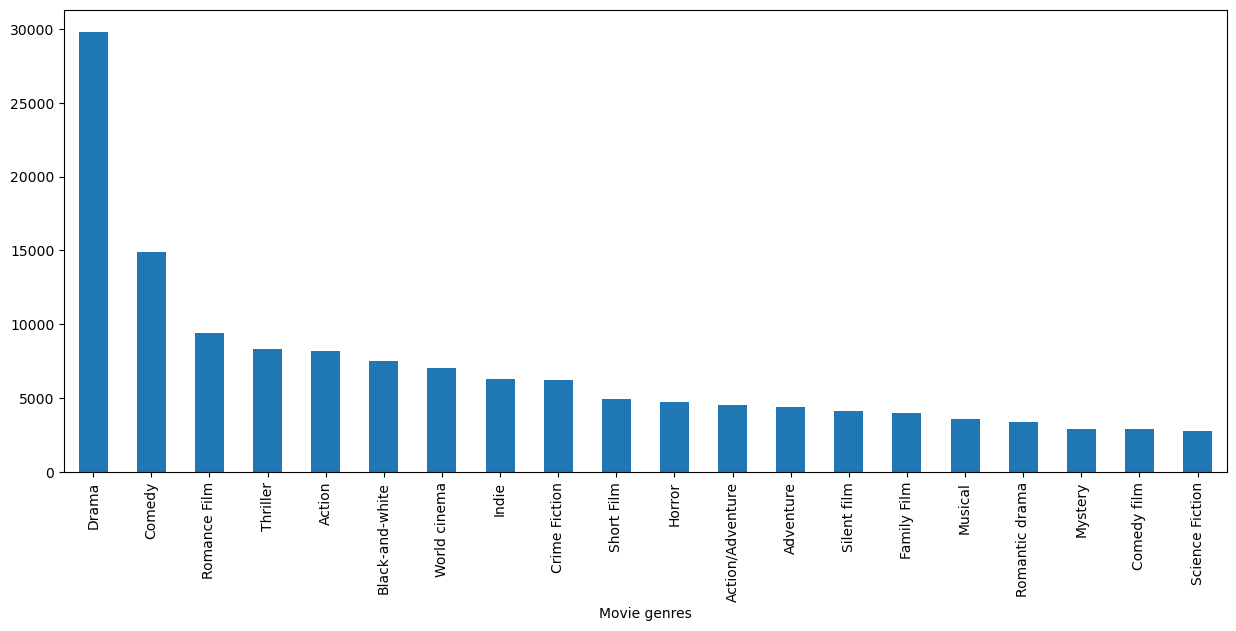

In [30]:
genre_counts = movies['Movie genres'].str.split(', ').explode().value_counts()
genre_counts

plt.figure(figsize=(15, 6))
genre_counts[:20].plot(kind='bar')

<Axes: xlabel='Movie release date'>

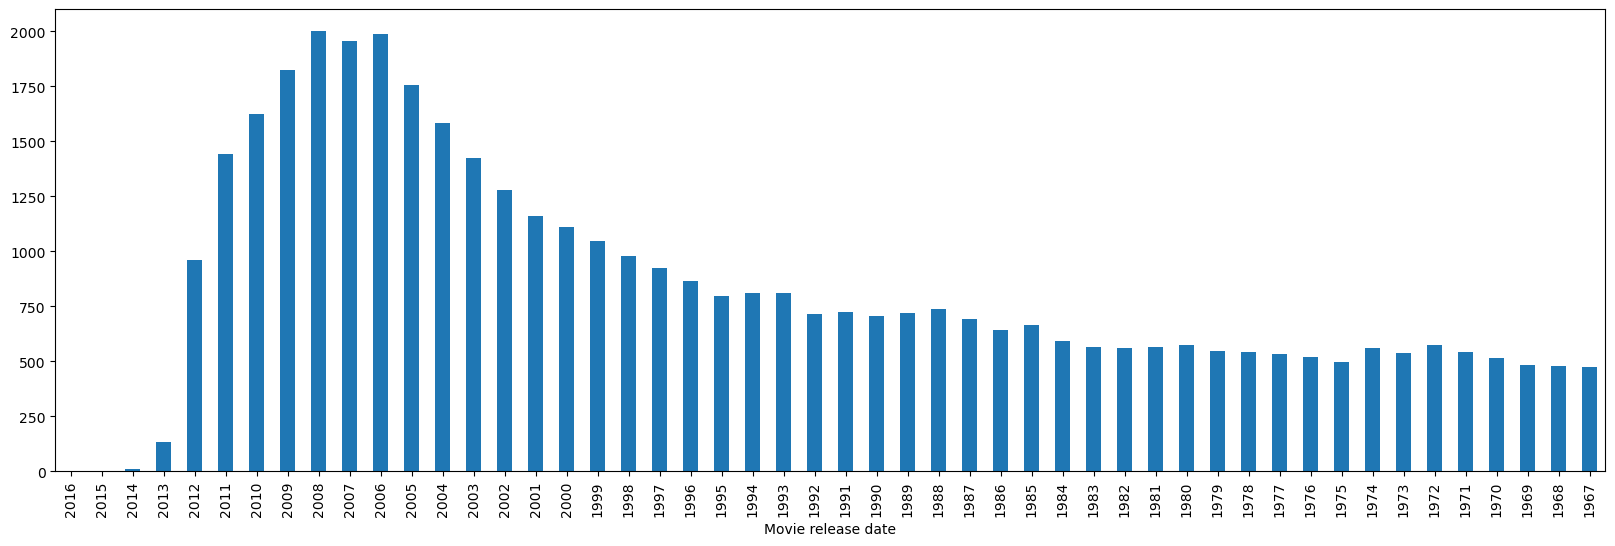

In [31]:
year_counts = movies['Movie release date'].value_counts()
#drop nan
year_counts = year_counts[year_counts.index.str.isnumeric()]
year_counts.sort_index(ascending=False, inplace=True)
plt.figure(figsize=(20, 6))
year_counts[:50].plot(kind='bar')

<Figure size 1500x800 with 0 Axes>

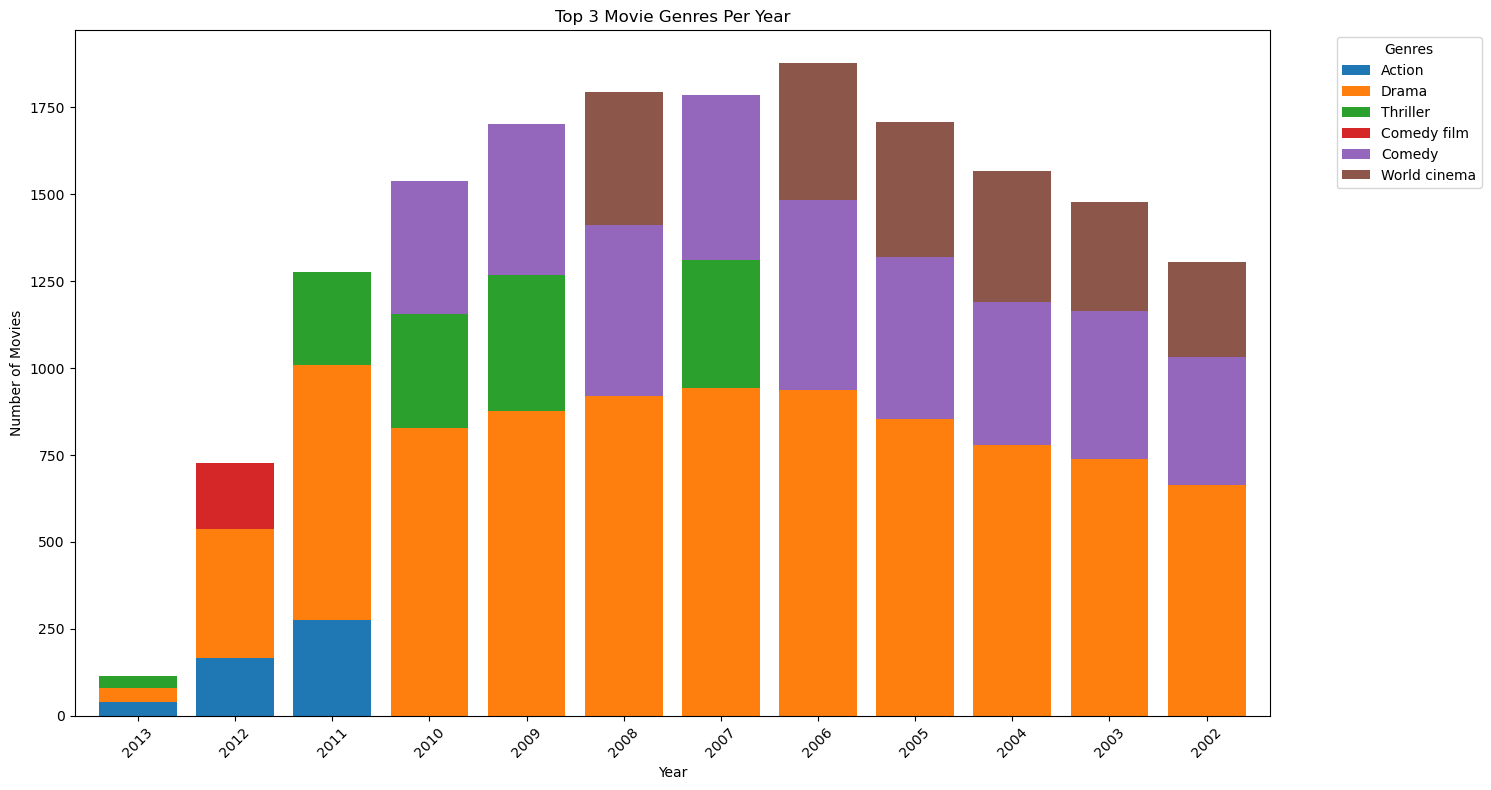

In [32]:
movies['Movie release date'] = pd.to_numeric(movies['Movie release date'], errors='coerce')

# Extract the last 10 years of data
recent_years = movies['Movie release date'].dropna().astype(int).sort_values(ascending=False).unique()[3:15]

top_genres_per_year = pd.DataFrame()

for year in recent_years:
    # Filter movies released in the current year
    movies_in_year = movies[movies['Movie release date'] == year]
    
    # Count the genres for movies in this year
    genre_counts = movies_in_year['Movie genres'].str.split(', ').explode().value_counts()
    
    # Get the top 3 genres and their counts
    top_genres = genre_counts.head(3)
    
    # Add the data to the DataFrame
    top_genres_per_year = pd.concat([top_genres_per_year, pd.DataFrame({year: top_genres})], axis=1)

# Transpose and clean up the DataFrame for plotting
top_genres_per_year = top_genres_per_year.T.fillna(0)

# Plotting the top 3 genres per year for the last 10 years
plt.figure(figsize=(15, 8))
top_genres_per_year.plot(kind='bar', stacked=True, figsize=(15, 8), width=0.8)

plt.title('Top 3 Movie Genres Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Axes: xlabel='Movie languages'>

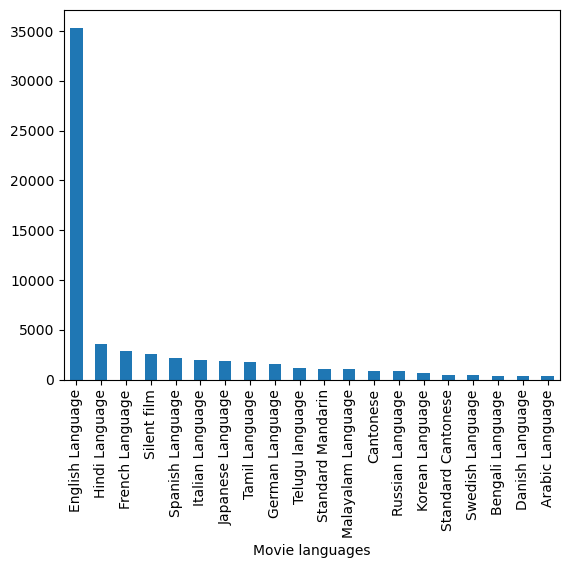

In [33]:
language_counts = movies['Movie languages'].str.split(', ').explode().value_counts()
language_counts
# remove the languages with less than 2 character
language_counts = language_counts[language_counts.index.str.len() > 1]
language_counts[:20].plot(kind='bar')

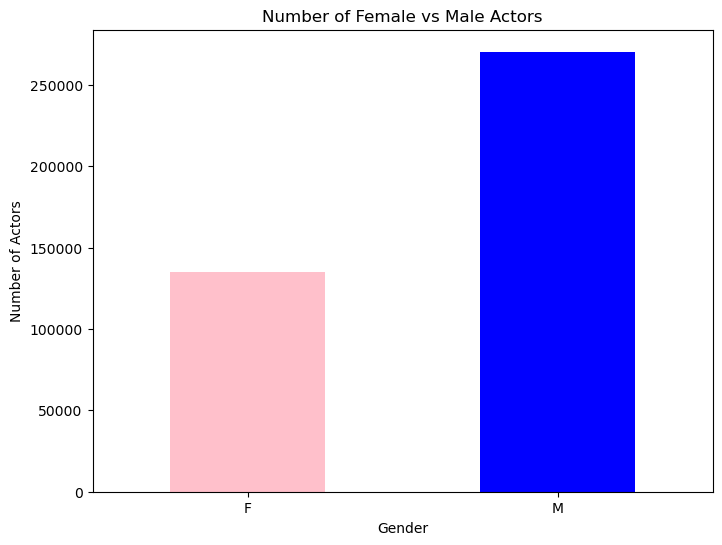

In [34]:
# Extract the 'Actor gender' column, split it by commas, and count the occurrences of 'F' and 'M'
gender_counts = movies['Actor gender'].str.split(', ').explode().value_counts()

plt.figure(figsize=(8, 6))
gender_counts[['F', 'M']].plot(kind='bar', color=['pink', 'blue'])
plt.title('Number of Female vs Male Actors')
plt.xlabel('Gender')
plt.ylabel('Number of Actors')
plt.xticks(rotation=0)
plt.show()

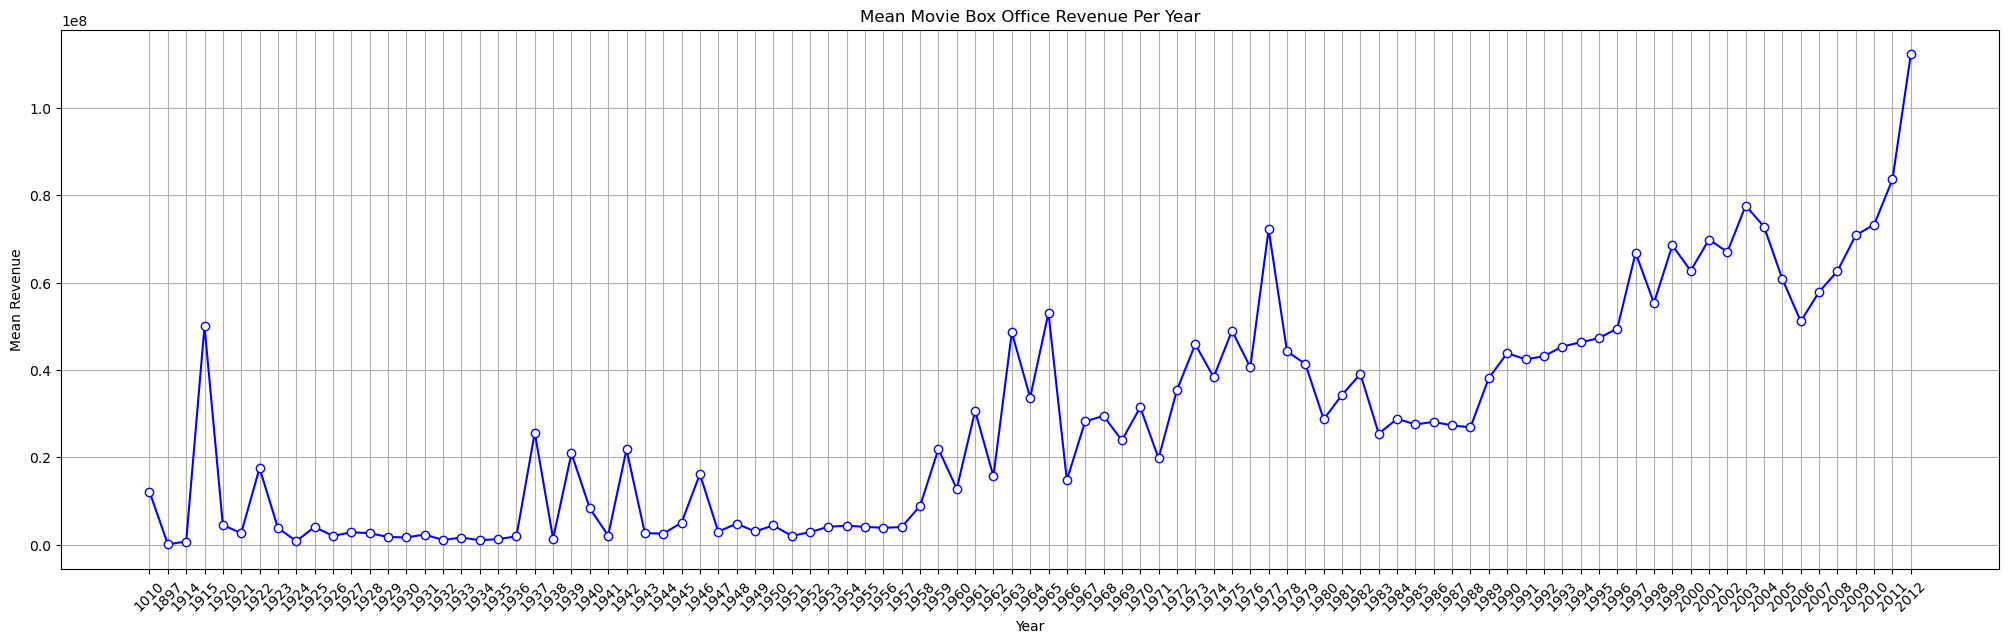

In [5]:
mean_revenue_per_year = movies.groupby('Movie release date')['Movie box office revenue'].mean()
mean_revenue_per_year = mean_revenue_per_year.dropna()
mean_revenue_per_year = mean_revenue_per_year[mean_revenue_per_year.index != "nan"]

plt.figure(figsize=(25, 7))
plt.plot(mean_revenue_per_year.index, mean_revenue_per_year.values, color='b', 
         marker='.', linestyle='solid', markersize=12, markerfacecolor='white')

plt.title('Mean Movie Box Office Revenue Per Year')
plt.xlabel('Year')
plt.ylabel('Mean Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

20k movies don't have any characters

We will not merge name clusters because there is a baseline bias - we would only consider movies that have been successful and have sequels

In [ ]:
# Add these imports
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess and vectorize the plot text
tfidf = TfidfVectorizer(
    max_features=1000,  # Limit to top 1000 terms
    stop_words="english",
    ngram_range=(1, 2),  # Consider both single words and bigrams
    min_df=5,  # Ignore terms that appear in less than 5 documents
)

# Create document-term matrix
plot_features = tfidf.fit_transform(movies["plot"])

# Reduce dimensionality (optional but recommended for better clustering)
svd = TruncatedSVD(n_components=100)
plot_features_reduced = svd.fit_transform(plot_features)

# Cluster the movies
n_clusters = 20  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
movies["cluster"] = kmeans.fit_predict(plot_features_reduced)


# Analyze the clusters
def get_top_terms_per_cluster():
    # Get the cluster centers in terms of the original TF-IDF features
    original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)

    for cluster in range(n_clusters):
        top_indices = np.argsort(original_space_centroids[cluster])[
            -10:
        ]  # Top 10 terms
        top_terms = [tfidf.get_feature_names_out()[i] for i in top_indices]
        print(f"\nCluster {cluster} top terms:")
        print(", ".join(top_terms))


# Display results
get_top_terms_per_cluster()